In [117]:
!pip install folium

In [178]:
!pip install geopandas==0.9.0

In [132]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import numpy as np
import random
from matplotlib import pyplot as plt
import folium 
import geopy
import rtree
import pygeos
from geopy.geocoders import Yandex, GoogleV3
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
%matplotlib inline

### Упражнение 1

In [133]:
def get_geodesic_distance(p1, p2):
    lat1, lat2 = np.radians(p1.x), np.radians(p2.x) #geographical latitude in radians
    delta_lon = np.radians(p2.y - p1.y) # difference in geographical longitude in radians
    
    a = (np.cos(lat2) * np.sin(delta_lon))**2 + (np.cos(lat1) * np.sin(lat2)
                                                 - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon))**2
    b = np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(delta_lon)
    
    central_angle = np.arctan2(np.sqrt(a), b)
    d = 6371 * central_angle
    return np.round(d, 15)

In [134]:
mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)
get_geodesic_distance(mipt, kremlin)

20.676951995783657

### Упражнение 2

In [142]:
big_moscow_districts = gpd.read_file('/Users/mac/Downloads/big_moscow_districts.shp')
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)

In [143]:
def get_k_nearest_neighbours_by_dist(polygon, polygons, k, kind):
    polygons_to_df = gpd.GeoDataFrame(crs = 4326, geometry = polygons)
    
    if kind == 'by_board':
        polygons_to_df['distance'] = polygons_to_df.distance(polygon)
        res = polygons_to_df.sort_values(by = 'distance', ignore_index = True).head(k)
        return(res)
    
    elif kind == 'by_centroid':
        polygons_to_df['centroid'] = polygons_to_df['geometry'].centroid 
        polygons_to_df['dist_centr'] = polygons_to_df['centroid'].distance(polygon.centroid) 
        res = polygons_to_df.sort_values(by=['dist_centr'], ignore_index =True).head(k) 
        return(res)

In [144]:
k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')

k_nearest_neighbours_by_centroid


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pygeos/measurement.py:58: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)


,geometry,centroid,dist_centr
0,"POLYGON ((37.73648 55.74586, 37.73632 55.74562...",POINT (37.70486 55.75366),0.036417
1,"POLYGON ((37.64488 55.77977, 37.64397 55.77969...",POINT (37.62879 55.78002),0.044125
2,"POLYGON ((37.67046 55.82442, 37.67032 55.82408...",POINT (37.65025 55.81228),0.050039
3,"POLYGON ((37.75422 55.75875, 37.75401 55.75871...",POINT (37.73067 55.77279),0.060136
4,"POLYGON ((37.63496 55.75379, 37.63445 55.75365...",POINT (37.60671 55.77021),0.064229
5,"POLYGON ((37.62641 55.74598, 37.62633 55.74597...",POINT (37.60746 55.73067),0.072906
6,"POLYGON ((37.67194 55.85043, 37.67176 55.84906...",POINT (37.64776 55.85186),0.088253
7,"POLYGON ((37.61085 55.81257, 37.61337 55.81084...",POINT (37.58943 55.81413),0.094236
8,"POLYGON ((37.73426 55.87864, 37.73551 55.87800...",POINT (37.73847 55.84286),0.101866
9,"POLYGON ((37.61174 55.74650, 37.61011 55.74526...",POINT (37.57496 55.72913),0.102975


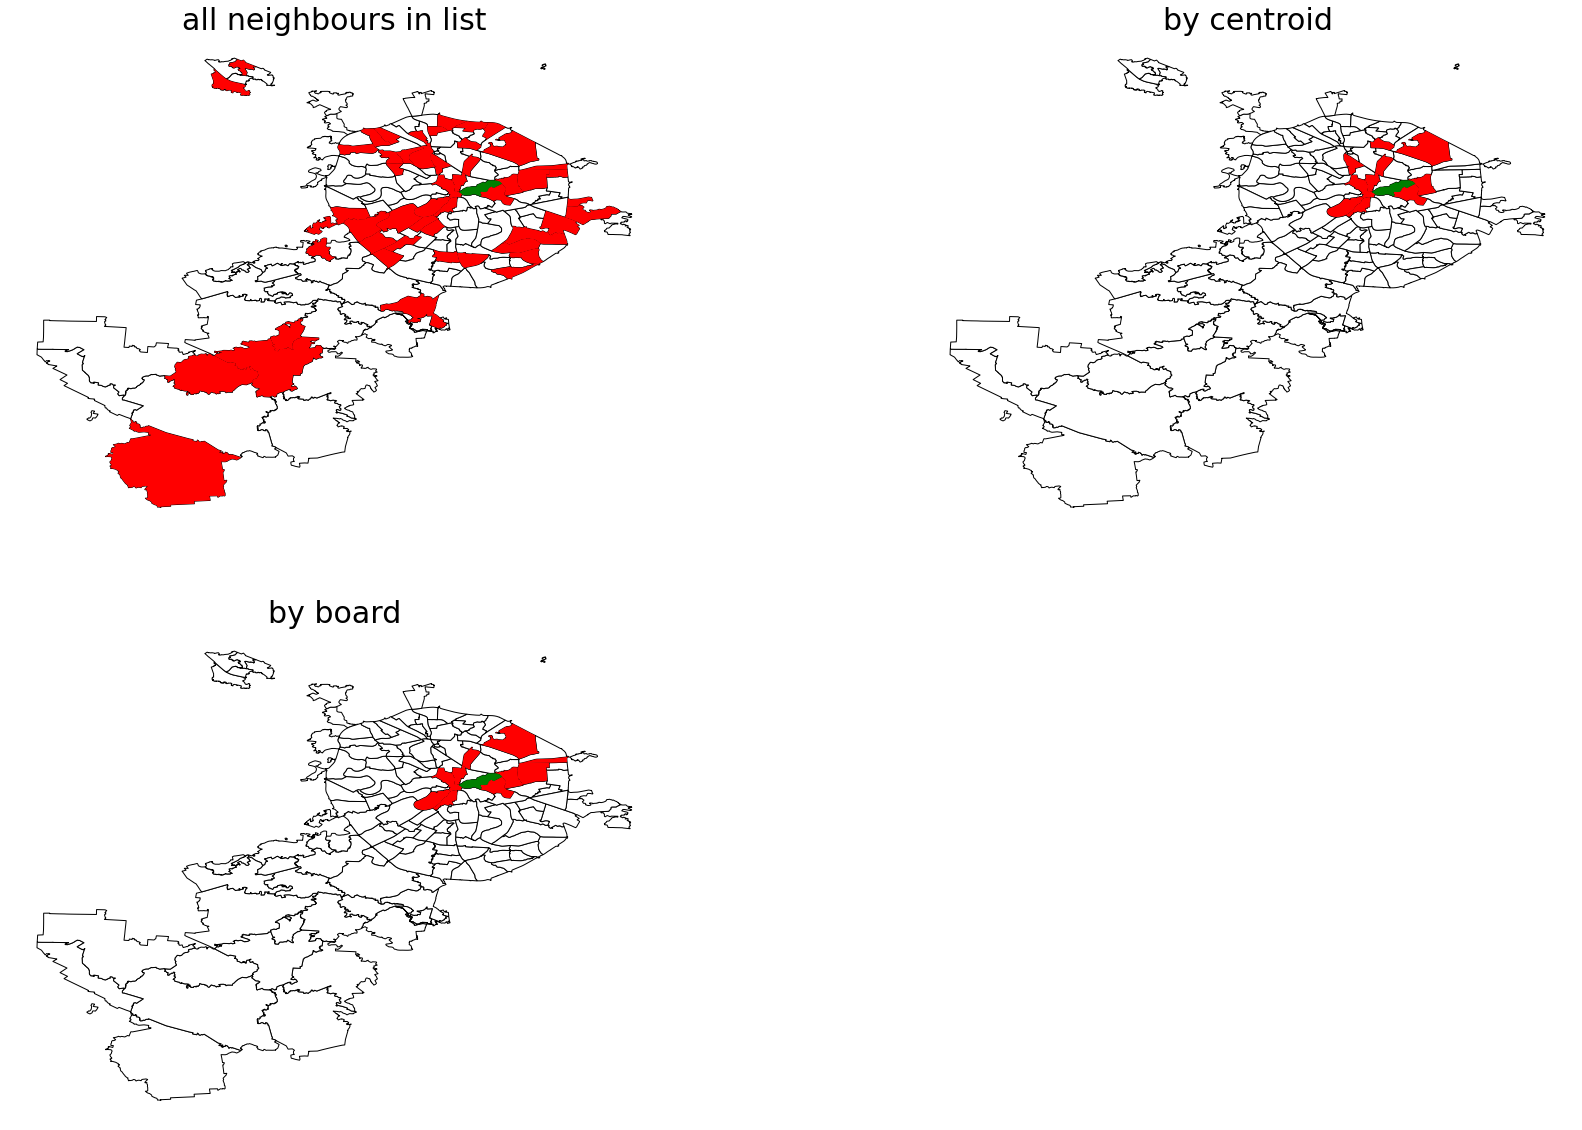

In [145]:
fig = plt.figure(figsize=(30, 20))

ax = plt.subplot(2, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
gpd.GeoSeries(polygons).plot(ax=ax, color= 'red')
plt.title('all neighbours in list', fontsize=30)
ax.set_axis_off() 

ax = plt.subplot(2, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
plt.title('by centroid', fontsize=30)
ax.set_axis_off()

ax = plt.subplot(2, 2, 3)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
plt.title('by board', fontsize=30)
ax.set_axis_off()


### Упражненение 3

In [162]:
grid_big_moscow = gpd.read_file('/Users/mac/Downloads/big_moscow_districts.shp')
grid_big_moscow.crs = "EPSG:4326"  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))
big_moscow_districts = gpd.GeoDataFrame(big_moscow_districts, crs = 4326)

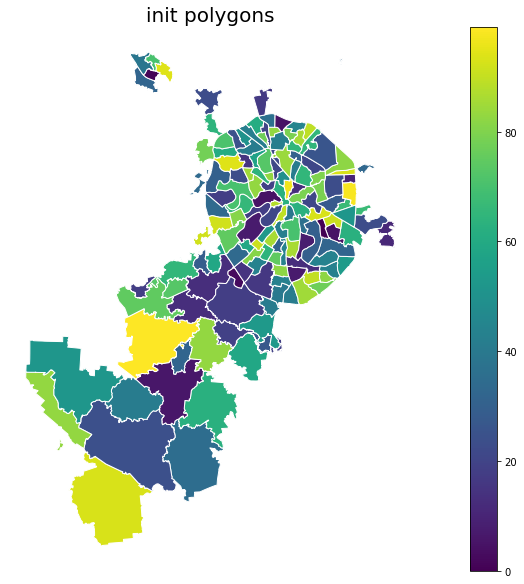

In [165]:
fig = plt.figure(figsize=(20, 10))
plt.title('init polygons', fontsize=20)
ax = plt.gca()
grid_big_moscow.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

In [208]:
def spatial_resample(agg_polygons, init_polygons, method, column, kind):
       
    def foo (extra_frame):

        if extra_frame['random_value_prop'] != extra_frame['max_value']:
            extra_frame[column] = 0
        return extra_frame
    
    init_polygons['FID'] = init_polygons.index
    
    agg_polygons['FID_2'] = agg_polygons.index
    
    init_polygons['area'] = init_polygons.geometry.area

    extra_frame = gpd.overlay(init_polygons, agg_polygons, how = 'intersection')

    extra_frame['intersection_area'] = extra_frame.geometry.area

    extra_frame['random_value_prop'] = ((extra_frame['intersection_area']
                                             * extra_frame[column])/extra_frame['area'])
    joined = gpd.sjoin(extra_frame, agg_polygons, how='right', op='covered_by')
    
    if kind == 'prop':
        
        return (joined.dissolve(by = joined.index, how = method ))
    
    
    elif kind == 'max':
        
        extra_frame['max_value']= extra_frame.groupby(['FID_1'])['random_value_prop'].transform(max)
        
        extra_frame = extra_frame.apply(foo, axis=1)
        
        joined_data = gpd.sjoin(extra_frame, agg_polygons, how = 'right', op='covered_by')
        
        return (joined_data.dissolve(by = joined_data.index, aggfunc= method))

In [214]:
grid_big_moscow.drop(['FID_1'])

KeyError: "['FID_1'] not found in axis"

In [211]:
grid_big_moscow

,FID,geometry,random_value,FID_1,area
0,0,"POLYGON ((37.68525 55.89508, 37.68891 55.89504...",89,0,0.000771
1,1,"POLYGON ((37.60716 55.87932, 37.60754 55.87911...",83,1,0.000473
2,2,"POLYGON ((37.64437 55.89768, 37.65226 55.89678...",45,2,0.000818
3,3,"POLYGON ((37.49625 55.89248, 37.49851 55.89347...",61,3,0.001016
4,4,"POLYGON ((37.41143 55.87096, 37.40632 55.87426...",64,4,0.001109
...,...,...,...,...,...
141,141,"MULTIPOLYGON (((37.31548 55.61297, 37.31545 55...",73,141,0.002181
142,142,"POLYGON ((37.13243 55.59919, 37.13442 55.60066...",18,142,0.001180
143,143,"POLYGON ((37.78505 55.61682, 37.78475 55.61683...",77,143,0.001014
144,144,"POLYGON ((37.64065 55.61046, 37.63994 55.61011...",43,144,0.000981


In [209]:
mean_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max')

ValueError: Grouper for 'FID_1' not 1-dimensional

In [160]:
sum_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='max')

ValueError: Grouper for 'FID_1' not 1-dimensional

In [161]:
mean_resample_table.head()

NameError: name 'mean_resample_table' is not defined

NameError: name 'sum_resample_table' is not defined

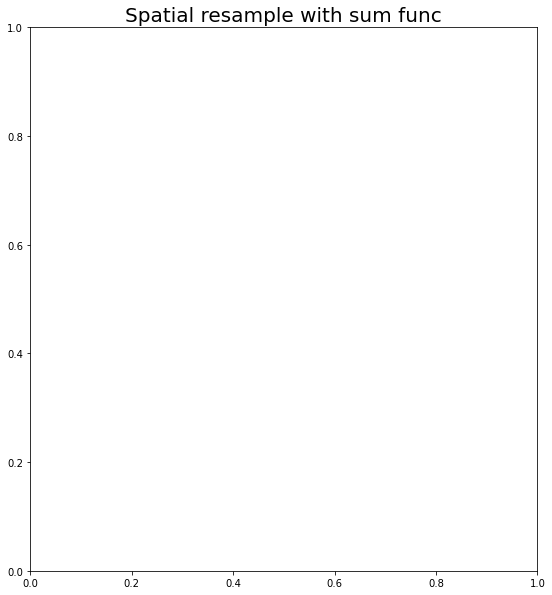

In [215]:
fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func', fontsize=20)
sum_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func', fontsize=20)
mean_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()
